# Model Training for Fakenews Detection

(Mặc định đã chạy notebook data-cleaning.ipynb để clean data và tạo dataset).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from nltk import word_tokenize
from nltk.corpus import stopwords
import re, string, os

import pickle as pkl

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Cho Linear Regression và SGDClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

# Cho Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Cho Random Forest và Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Cho thuật KNN
from sklearn.neighbors import KNeighborsClassifier

# Cho Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Cho Support Vector Machine
from sklearn.svm import LinearSVC

Load dataset đã tạo với notebook clean data.

In [3]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

Tương quan giữa các class 0 (fake news) và 1 (true news) trên tập train

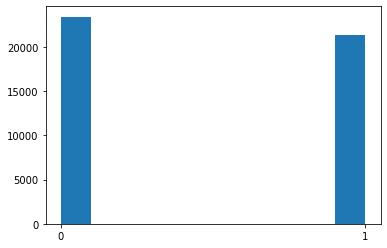

In [4]:
plt.figure()
plt.hist(df_train['class'])
plt.xticks(df_train['class'].unique())
plt.show()

Số lượng item của mỗi tập xấp xỉ nhau nên không sợ unbalanced. Nếu unbalanced thì có 2 lựa chọn:
- Undersampling: "Chặt" bớt data của tập nhiều hơn cho 2 (các) tập xấp xỉ (hoặc bằng) nhau. Ca này khó đỡ nếu 2 (các) tập lệch quá nhiều.
- Oversampling: generate thêm data cho (các) tập ít hơn. Ca này dễ sinh ra nhiều câu vl, khó kiểm soát.

Tóm lại: chả cần oversampling hay undersampling làm gì cả, train thôi!

## Tiền xử lý text
Gồm các bước sau:
- Chuyển text về dạng lowercase.
- Loại bỏ các dấu ngoặc.
- Loại bỏ các ký tự đặc biệt (chỉ cho phép a-z, A-Z, 0-9), thay thế bằng dấu cách.
- Loại bỏ html tags.
- Loại bỏ dấu câu (string punctuations).
- Loại bỏ dấu xuống dòng.
- Loại bỏ số trong câu.

In [5]:
def preprocess(text):
    punctuations = '[{0}]'.format(string.punctuation)
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\\W', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(punctuations, '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

Áp dụng text preprocessing với df_train

In [6]:
df_train['text'].apply(preprocess)

0        shawn helton  century wireon the eve of the  a...
1        washington  reuters    democratic presidential...
2         join patrick every wednesday at independent t...
3        coming to a town near you a sign was hung in a...
4        new york  reuters    while donald trump s poli...
                               ...                        
44793    abuja  reuters    the united states has formal...
44794    tune in to the alternate current radio network...
44795    ed henry of fox news tells us tonight that hil...
44796    washington  reuters    the republican tax plan...
44797    sydney  reuters    the u n  high commissioner ...
Name: text, Length: 44798, dtype: object

Cũng áp dụng tương tự với df_test

In [7]:
df_test['text'].apply(preprocess)

0     episode   of sunday wire show finally resumes ...
1      century wire says this is a new geopolitical ...
2      century wire says unless you have been living...
3     brussels  reuters    nato allies on tuesday we...
4     united nations  reuters    two north korean sh...
                            ...                        
95     inversewikileaks released tonight a new cache...
96     century wire says iowa s democratic party pri...
97    ottawa  reuters    canada fears a huge surge i...
98    vic bishop waking timesour reality is carefull...
99     truthstream mediaout of  potential horrors th...
Name: text, Length: 100, dtype: object

## Train model

Tạo folder lưu model sau khi train

In [8]:
model_dir = 'model/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

Load tập train và test

In [9]:
X_train = df_train['text']
y_train = df_train['class']

In [10]:
X_test = df_test['text']
y_test = df_test['class']

X cần được chuyển thành vector trước khi đưa vào các model. Ở đây ta dùng TF-IDF vectorizer.

In [11]:
vectorizer = TfidfVectorizer(
    stop_words = stopwords.words('english'),
    tokenizer = word_tokenize
)
XVector_train = vectorizer.fit_transform(X_train)

# Test không có fit!
XVector_test = vectorizer.transform(X_test)

D:\Software\Python\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


vectorizer này bao gồm bộ từ vựng (vocabulary) và điểm TF-IDF của từng từ trong văn bản train ban đầu.

Cho dễ hiểu là ta không cần bắt model "học thuộc" toàn bộ câu, mà chỉ ra câu đó có những đặc điểm gì đặc biệt để nhận biết nó thuộc class nào. Các "đặc điểm" này là những keyword và điểm TF-IDF của keyword đó. (đọc thêm tài liệu về [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))

Đối với vector train, ta "fit" - thực hiện trích xuất câu thành keywords và "học" các keyword đó.

Đối với vector test, ta chỉ transform - biến các câu test thành danh sách các keyword đã "học" lúc fit.

In [12]:
# Export vectorizer ra file pickle
with open(model_dir + 'vectorizer.pkl', 'wb') as f:
    pkl.dump(vectorizer, f)

### sklearn.linear_model

#### Logistic Regression

In [13]:
logistic_model = LogisticRegression()
logistic_model.fit(XVector_train, y_train)

LogisticRegression()

In [14]:
logistic_model.score(XVector_test, y_test)

0.99

In [15]:
predict_logistic_regression = logistic_model.predict(XVector_test)
print(classification_report(y_test, predict_logistic_regression))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.98      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



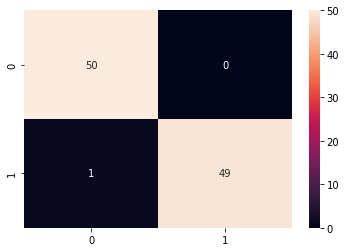

In [16]:
logistic_cm = confusion_matrix(y_test, predict_logistic_regression)
sns.heatmap(logistic_cm, annot = True)
plt.show()

In [17]:
# Export model ra file pickle
with open(model_dir + 'logistic_regression.pkl', 'wb') as f:
    pkl.dump(logistic_model, f)

#### SGD Classifier
Là thằng [Support Vector Classifier](#LinearSVC---Linear-Support-Vector-Classifier), nhưng giờ sẽ dùng SGD learning. Đọc kỹ hơn trên site của sklearn!

In [18]:
sgd_model = SGDClassifier(random_state = 42)
sgd_model.fit(XVector_train, y_train)

SGDClassifier(random_state=42)

In [19]:
sgd_model.score(XVector_test, y_test)

0.99

In [20]:
predict_sgd = sgd_model.predict(XVector_test)
print(classification_report(y_test, predict_sgd))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.98      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



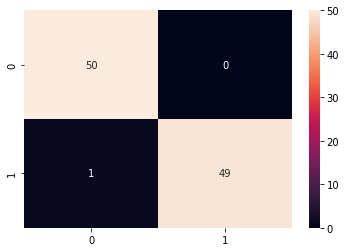

In [21]:
sgd_cm = confusion_matrix(y_test, predict_sgd)
sns.heatmap(sgd_cm, annot = True)
plt.show()

Nhận xét:
- Sai y chang Linear Regression
- Chạy nhanh

In [22]:
# Export ra file pickle
with open(model_dir + 'sgd_classifier.pkl', 'wb') as f:
    pkl.dump(sgd_model, f)

### sklearn.tree

#### Decision Tree Classification

In [23]:
decision_model = DecisionTreeClassifier(random_state = 42)
decision_model.fit(XVector_train, y_train)

DecisionTreeClassifier(random_state=42)

In [24]:
decision_model.score(XVector_test, y_test)

1.0

In [25]:
predict_decision_tree = decision_model.predict(XVector_test)
print(classification_report(y_test, predict_decision_tree))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



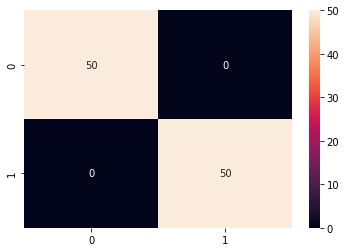

In [26]:
decision_cm = confusion_matrix(y_test, predict_decision_tree)
sns.heatmap(decision_cm, annot = True)
plt.show()

Nhận xét: Accuracy tăng, model này tốt hơn Logistic Regression.

In [27]:
# Export ra file pickle
with open(model_dir + 'decision_tree.pkl', 'wb') as f:
    pkl.dump(decision_model, f)

### sklearn.ensemble

#### Gradient Boosting Classification

In [28]:
gradient_model = GradientBoostingClassifier(random_state = 42)
gradient_model.fit(XVector_train, y_train)

GradientBoostingClassifier(random_state=42)

In [29]:
gradient_model.score(XVector_test, y_test)

1.0

In [30]:
predict_gradient_boosting = gradient_model.predict(XVector_test)
print(classification_report(y_test, predict_gradient_boosting))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



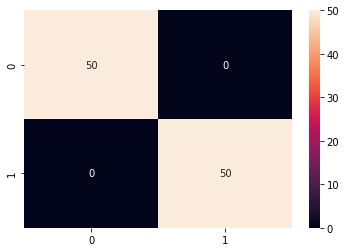

In [31]:
gradient_cm = confusion_matrix(y_test, predict_gradient_boosting)
sns.heatmap(gradient_cm, annot = True)
plt.show()

Nhận xét: 
- nhìn thì có vẻ đã improve hơn Decision Tree nhưng thuật chạy lâu hơn Decision Tree.

Vì vậy nếu ưu tiên thì mình sẽ chọn Decision Tree nhiều hơn.

In [32]:
# Export ra file pickle
with open(model_dir + 'gradient_boosting.pkl', 'wb') as f:
    pkl.dump(gradient_model, f)

#### Random Forest Classification

In [33]:
forest_model = RandomForestClassifier(random_state = 42)
forest_model.fit(XVector_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
forest_model.score(XVector_test, y_test)

1.0

In [35]:
predict_random_forest = forest_model.predict(XVector_test)
print(classification_report(y_test, predict_random_forest))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



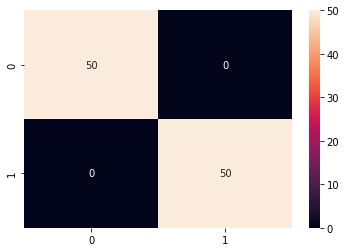

In [36]:
forest_cm = confusion_matrix(y_test, predict_random_forest)
sns.heatmap(forest_cm, annot = True)
plt.show()

Nhận xét:
- Nhanh hơn Gradient Boosting.
- Accuracy kém hơn Gradient Boosting.

In [37]:
# Export ra file pickle
with open(model_dir + 'random_forest.pkl', 'wb') as f:
    pkl.dump(forest_model, f)

### sklearn.neighbors

#### k-Nearest Neighbors

Chú ý là đừng có lộn n_neighbors với số class, nó chẳng liên quan gì hết.

In [38]:
neighbors_model = KNeighborsClassifier(n_neighbors = 1, weights = 'distance')
neighbors_model.fit(XVector_train, y_train)

KNeighborsClassifier(n_neighbors=1, weights='distance')

In [39]:
neighbors_model.score(XVector_test, y_test)

0.81

In [40]:
predicted_neighbors = neighbors_model.predict(XVector_test)
print(classification_report(y_test, predicted_neighbors))

              precision    recall  f1-score   support

           0       0.72      1.00      0.84        50
           1       1.00      0.62      0.77        50

    accuracy                           0.81       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.86      0.81      0.80       100



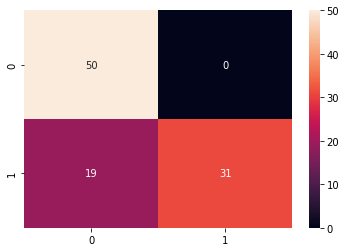

In [41]:
neighbors_cm = confusion_matrix(y_test, predicted_neighbors)
sns.heatmap(neighbors_cm, annot = True)
plt.show()

Nhận xét:
- Accuracy thấp hơn Gradient Boosting
- Chậm hơn Gradient Boosting

Nên recommend không xài cái này.

In [42]:
# Export ra file pickle
with open(model_dir + 'k_neighbors.pkl', 'wb') as f:
    pkl.dump(neighbors_model, f)

### sklearn.naive_bayes

#### Multinomial Naive Bayes

Là Naive Bayes, nhưng dùng [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution)

In [43]:
multinomial_bayes_model = MultinomialNB()
multinomial_bayes_model.fit(XVector_train, y_train)

MultinomialNB()

In [44]:
multinomial_bayes_model.score(XVector_test, y_test)

0.95

In [45]:
predicted_multinomial = multinomial_bayes_model.predict(XVector_test)
print(classification_report(y_test, predicted_multinomial))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        50
           1       0.92      0.98      0.95        50

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



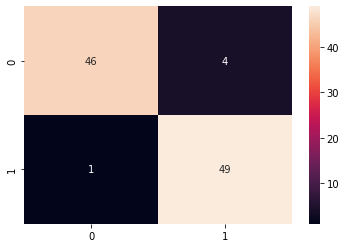

In [46]:
multinomial_cm = confusion_matrix(y_test, predicted_multinomial)
sns.heatmap(multinomial_cm, annot = True)
plt.show()

Nhận xét: accuracy chưa cao như một số model bên trên, nhưng cũng nhanh hơn mấy thuật bên ensemble.

In [47]:
# Export ra file pickle
with open(model_dir + 'naive_bayes.pkl', 'wb') as f:
    pkl.dump(multinomial_bayes_model, f)

### sklearn.svm

#### LinearSVC - Linear Support Vector Classifier
Dùng hàm tuyến tính để classify bộ dataset.

In [48]:
linear_svc_model = LinearSVC(random_state = 42)
linear_svc_model.fit(XVector_train, y_train)

LinearSVC(random_state=42)

In [49]:
linear_svc_model.score(XVector_test, y_test)

0.99

In [50]:
predict_linear_svc = linear_svc_model.predict(XVector_test)
print(classification_report(y_test, predict_linear_svc))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.98      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



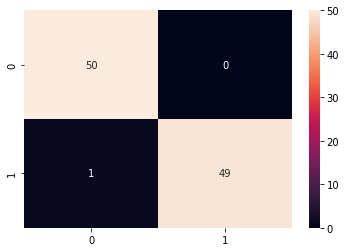

In [51]:
linear_svc_cm = confusion_matrix(y_test, predict_linear_svc)
sns.heatmap(linear_svc_cm, annot = True)
plt.show()

Nhận xét:
- Nhìn có vẻ khả quan, predict sai cũng ít (tất nhiên không ít bằng Decision Tree)

In [52]:
# Export ra file pickle
with open(model_dir + 'linear_svc.pkl', 'wb') as f:
    pkl.dump(linear_svc_model, f)

## Tổng kết
So sánh (nhanh) các thuật (xét cùng random_state và tập train, test):

|Thuật|Accuracy|Số câu sai|Note|
|:----|--------|----------|----|
|sklearn.ensemble.GradientBoostingClassifier|1|0|(chạy lâu)|
|sklearn.tree.DecisionTreeClassifier|1|0||
|sklearn.svm.LinearSVC|0.99|1||
|sklearn.linear_model.SGDClassifier|0.99|1||
|sklearn.ensemble.RandomForest|0.99|1||
|sklearn.linear_model.LogisticRegression|0.99|1||
|sklearn.naive_bayes.MultinomialNB|0.93|7||
|sklearn.neighbors.KNeighborsClassifier|0.82|18|(chạy lâu)|

- Thực ra nhìn là biết xài tree sẽ hiệu quả nhất (xét ngữ cảnh đã học ID3 và thấy nó pro vip thế nào với bộ Iris).
- Gradient Boosting cũng xài tree, nhưng số iteration nhiều dẫn đến chạy lâu!
- Thằng K-Neighbors là thằng vl nhất, đoán được K đúng là 1 vấn đề.

## Further works

### Export vectorizer và model cần dùng ra file pickle để load lên xài.

More detailed instruction: 
- Đầu vào: đoạn văn cần đánh giá real/fake news.
- Đầu ra: label 0 (fake) hoặc 1 (real).

The Pipeline™:
1. Dùng hàm preprocess() để tiền xử lí câu,
2. Load model và vectorizer lên từ file pickle.
3. Dùng vectorizer transform câu thành danh sách các keyword đã có trong vectorizer.
4. Dùng model predict label, sau đó output.

### Still a text classification problem, but now try to guess the article's topic instead.
Gợi ý: đã có cột `subject` trong data ban đầu!

Extra-gợi ý: chú ý đây là bài toán multiclass, không còn 2 class như bài toán fakenews detection!